## Construction of Hess Diagram

**Input**: GCWD21+Golovin24 WD sample and pre-selected 50-pc MS sample with deblended G-RP color (step 1a), applied quality cuts (step 1b), and probability of parallax to be greater than 20 mas (criterium of belonging to the 50-pc sphere) 

**Method**: Generate 2d-histogram in (M_G,G-RP_deblended) coords, apply smoothing. Stars are weighted with the probability column. 

**Output**: Hess diagram for 50 pc - for all stars and separately for WD and MS.

In [1]:
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt 

from helpers import HessConstructor

In [2]:
def generate_hess(mag_range,mag_step,mag_smooth,mode='ms+wd'):

    table_wd = Table.read('data/wd_sample_50pc_w.csv')
    table_ms = Table.read('data/ms_sample_50pc_w.csv')

    if mode == 'ms':
        table_wd = table_wd[0:0] # ignore white dwarfs
    if mode == 'wd':
        table_ms = table_ms[0:0] # ignore main sequence
    
    # All stars
    hess = HessConstructor.hess_from_data(
        np.concatenate((table_ms['g_rp_deblended'],table_wd['g_rp_deblended']),axis=-1), 
        np.concatenate((table_ms['M_G'],table_wd['M_G']),axis=-1), 
        mag_range=mag_range,
        mag_step=mag_step,
        mag_smooth=mag_smooth,
        weights=np.concatenate((table_ms['weights'],table_wd['weights']),axis=-1)
        )

    # MS
    hess_ms = HessConstructor.hess_from_data(
        table_ms['g_rp_deblended'], 
        table_ms['M_G'],
        mag_range=mag_range,
        mag_step=mag_step,
        mag_smooth=mag_smooth,
        weights=table_ms['weights']
    )

    # WD
    hess_wd = HessConstructor.hess_from_data(
        table_wd['g_rp_deblended'],
        table_wd['M_G'],
        mag_range=mag_range,
        mag_step=mag_step,
        mag_smooth=mag_smooth,
        weights=table_wd['weights']
    )

    N_ms = int(sum(sum(hess_ms)))
    N_wd = int(sum(sum(hess_wd)))
    N_tot = int(N_ms + N_wd)
    
    # Plot numbers in log scale
    log10_hess = np.log10(hess.T + 1)  # Add 1 to avoid log(0)

    xmin, xmax = mag_range[0]
    ymin, ymax = mag_range[1]
    hmin, hmax = 0,np.nanmax(log10_hess)

    fig, ax = plt.subplots(figsize=(10, 8))
    im = ax.imshow(log10_hess, interpolation='none',cmap='magma', 
                extent=[xmin,xmax,ymax,ymin], vmin=hmin, vmax=hmax)
    ax.set_xlabel(r'$\mathrm{G - G_{RP}}$')
    ax.set_ylabel(r'$\mathrm{M_G}$')
    ax.set_aspect((xmax-xmin)/(ymax-ymin))

    if mode != 'wd':
        ax.text(0.8,0.95,r'{:<10}'.format(r'$\mathrm{N_{MS}') + '=' + str(N_ms)+'}$',
                color='w',transform=ax.transAxes)
    if mode != 'ms':
        ax.text(0.8,0.92,r'{:<10}'.format(r'$\mathrm{N_{WD}') + '=' + str(N_wd)+'}$',
                color='w',transform=ax.transAxes)
    if mode == 'ms+wd':
        ax.text(0.8,0.89,r'$\mathrm{N_{tot}='+str(N_tot)+'}$',
                color='w',transform=ax.transAxes)

    fig.subplots_adjust(bottom=0.18,left=0.08,right=0.94,top=0.93)
    pos = ax.get_position()
    cax = fig.add_axes([pos.x0+pos.width+0.02,pos.y0,0.025,pos.height])
    cbar = fig.colorbar(im,cax=cax,orientation='vertical')
    cbar.set_label(r'$\mathrm{log_{10} \ N \ [' + str(mag_step[0]) +
                   r'\times' + str(mag_step[1]) + r'] \ mag^{-2}}$', labelpad=10)
    fig.savefig('data/hess/hess_' + mode + '.png')
    plt.show()

    if mode == 'ms+wd':
        np.savetxt('data/hess/hess_tot.txt', hess.T)
    if mode == 'ms':
        np.savetxt('data/hess/hess_ms.txt', hess_ms.T)
    if mode == 'wd':
        np.savetxt('data/hess/hess_wd.txt', hess_wd.T)


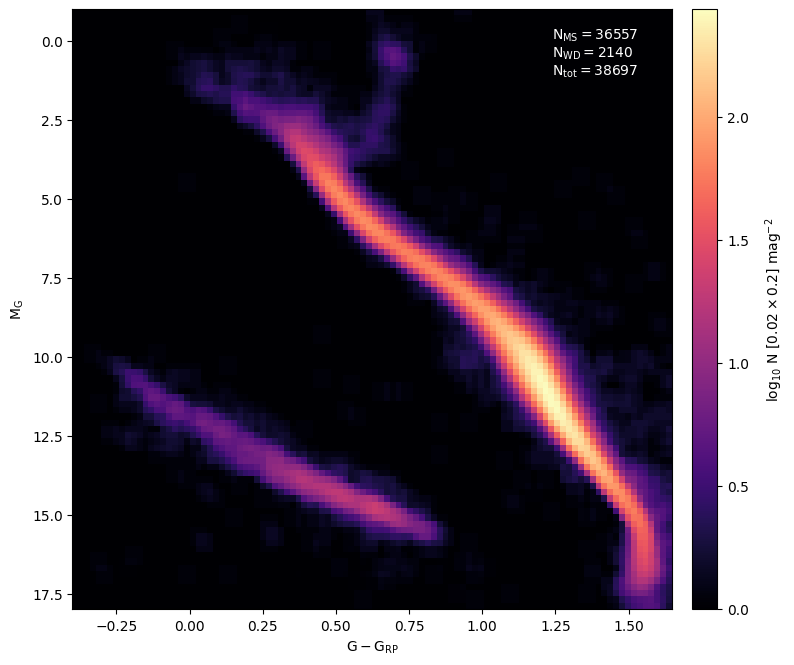

In [6]:
mag_range = [[-0.4,1.65],[-1,18]]
mag_step = [0.02,0.2]
mag_smooth = [0.06,0.8]

mode = 'ms+wd'

generate_hess(mag_range,mag_step,mag_smooth,mode=mode)